### Libraries

In [1]:
#General
import re, os, string, io, sys, types, time

#Validation
from sklearn import cross_validation, datasets, preprocessing
##All Algos
from sklearn import svm, linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.learning_curve import learning_curve
from sklearn.metrics import roc_curve, auc

#Custom built
from findMyNotebook import find_notebook
import findMyNotebook
from data_filtering import NumericalizeData    #see DataFiltering.ipynb (yes, it is a python notebook!!)
from fitting_report import FittingReport
from grid_search import gridSearch
from plot_learning_curve import plotLearningCurve
from plot_roc import plotRoc
from dataAnalyzer import AnalyzeData
from create_plot_frame import createFrame
from plot_confusion_matrix import plotConfusionMatrix

import warnings
warnings.filterwarnings('ignore')

/Users/yogeshluthra/Documents/OneDrive/iPython/scikit-learn/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


None


/Users/yogeshluthra/Documents/OneDrive/iPython/scikit-learn/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/yogeshluthra/Documents/OneDrive/iPython/scikit-learn/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Global Settings

-  Plot settings  
 -  Reference : http://matplotlib.org/users/customizing.html  

In [2]:
# font = {
#        'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 10
# }
#plt.rc('font', **label)

# axes = {
#        'titlesize'  : 10,
#         'labelsize'  : 12
# }
# plt.rc('axes', **axes)

legend = {
    'fontsize' : 10
}
plt.rc('legend', **legend)

# figure = {
#             'figsize' : (3,3),
#           'titlesize' : 12
#             }
# plt.rc('figure', **figure)
#plt.rcParams.update({'font.size': 22}) ##To update at any point in code

### Load Data in Structures

In [3]:
uciData_path='/Users/yogeshluthra/Documents/OneDrive/OMCS GeorgiaTech/Machine Learning/UCI_datasets'

#currData=re.escape('crx.data')
currData='german.data'

df=pd.read_csv(uciData_path+'/'+currData, sep='[,\t\s]+', header=None, engine='python')
attributes=['A'+str(colnum) for colnum in range(1,len(df.columns))]
attributes.append('Label')
df.columns = attributes
print(df.head(n=3))
print("instances: "+str(len(df.index))+"\t attributes: "+str(len(df.columns)))

    A1  A2   A3   A4    A5   A6   A7  A8   A9   A10  ...    A12 A13   A14  \
0  A11   6  A34  A43  1169  A65  A75   4  A93  A101  ...   A121  67  A143   
1  A12  48  A32  A43  5951  A61  A73   2  A92  A101  ...   A121  22  A143   
2  A14  12  A34  A46  2096  A61  A74   2  A93  A101  ...   A121  49  A143   

    A15 A16   A17 A18   A19   A20 Label  
0  A152   2  A173   1  A192  A201     1  
1  A152   1  A173   1  A191  A201     2  
2  A152   1  A172   2  A191  A201     1  

[3 rows x 21 columns]
instances: 1000	 attributes: 21


#### Replace missing values with np.nan

In [4]:
replacementDict={'?':np.nan, 
                 '-':np.nan}

In [5]:
df=df.replace(replacementDict)
print("Any missing values? {0}".format(df.isnull().values.any()))

Any missing values? False


#### Save data for sanity check

In [6]:
df.to_csv(uciData_path+'/'+currData+'.csv', sep=',', index=False)   #no index column. Separated by tab
print("processed csv saved in:")
print(uciData_path+'/'+currData+'.csv')

processed csv saved in:
/Users/yogeshluthra/Documents/OneDrive/OMCS GeorgiaTech/Machine Learning/UCI_datasets/german.data.csv


#### Use DataSet
-  Add new class labels at random locations

In [7]:
y=df['Label'].values

le = preprocessing.LabelEncoder()
le.fit(y)
class_names=le.classes_
y=le.transform(y)
classes=sorted(set(y), reverse=True)
n_classes=len(classes)

print("class values: {0}".format(classes))
print y[:5]

X=df.ix[:,:-1].values
print("target shape: {0} \t attribute shape: {1}".format(y.shape, X.shape))

class values: [1, 0]
[0 1 0 0 1]
target shape: (1000,) 	 attribute shape: (1000, 20)


##### Some data usage example

In [8]:
x_curr=X[:5,0]        #creates row vector
x_curr=X[:5,[0]]      #creates col vector
x_curr=X[np.array(range(5)),:5]    #print matrix of 5x5
x_curr=X[np.array(range(5)),np.array([0,1,2,3,4])]    #diagonal slicing
print x_curr

['A11' 48 'A34' 'A42' 4870]


In [9]:
print ['c' for i in range(X.shape[1])]    # copy paste for attribute types below

['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


### Data preprocessing
-  One-Hot encoding for categorical features  
-  Mean normalization for numerical attributes (if doNorm is True)  
-  Imputing of Nominal and Numeric attribute values
  -  If doImpute==False and removeMissing==True   remove instances with any missing missing attribute value
-  label binarization  

In [10]:
attrTypes=['c', 'n', 'c', 'c', 'n', 'c', 'c', 'n', 'c', 'c', 'n', 'c', 'n', 'c', 'c', 'n', 'c', 'n', 'c', 'c']
print "just for check"
print zip(X[0,:],attrTypes)

print("Attribute shape (before): {0}".format(X.shape))
(X, enc_nom, enc_num)=NumericalizeData(X, attrTypes)
print("enc_nom classes {0}".format(enc_nom.classes_))
print("enc_num samples seen {0}".format(enc_num.n_samples_seen_))
print("Attribute shape (after): {0}".format(X.shape))

just for check
[('A11', 'c'), (6, 'n'), ('A34', 'c'), ('A43', 'c'), (1169, 'n'), ('A65', 'c'), ('A75', 'c'), (4, 'n'), ('A93', 'c'), ('A101', 'c'), (4, 'n'), ('A121', 'c'), (67, 'n'), ('A143', 'c'), ('A152', 'c'), (2, 'n'), ('A173', 'c'), (1, 'n'), ('A192', 'c'), ('A201', 'c')]
Attribute shape (before): (1000, 20)
Imputing dataset...
enc_nom classes ['A101' 'A102' 'A103' 'A11' 'A12' 'A121' 'A122' 'A123' 'A124' 'A13' 'A14'
 'A141' 'A142' 'A143' 'A151' 'A152' 'A153' 'A171' 'A172' 'A173' 'A174'
 'A191' 'A192' 'A201' 'A202' 'A30' 'A31' 'A32' 'A33' 'A34' 'A40' 'A41'
 'A410' 'A42' 'A43' 'A44' 'A45' 'A46' 'A48' 'A49' 'A61' 'A62' 'A63' 'A64'
 'A65' 'A71' 'A72' 'A73' 'A74' 'A75' 'A91' 'A92' 'A93' 'A94']
enc_num samples seen 1000
Attribute shape (after): (1000, 61)


In [11]:
X[0,:]

array([ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        , -1.23647786,
       -0.74513141,  0.91847717,  1.04698668,  2.76645648,  1.02707891,
       -0.42828957])

### Split Train and Test sets

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)
algoMetric={}
clfs_plots={}

#### *Note:
-  Params to algo can be passed as:
  -  e.g. svm.SVC(\**params) 
    -  where params is a mapping
    -  see http://scikit-learn.org/dev/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py

### Grid Searches on Train Data
-  SVM Poly

Best parameters set found on development set:
{'coef0': 100.0, 'gamma': 0.001, 'degree': 2}


Grid scores on development set:
--------------------
1 0.698 (+/-0.007) for {'coef0': 0.01, 'gamma': 0.001, 'degree': 2}
2 0.739 (+/-0.028) for {'coef0': 0.01, 'gamma': 0.031622776601683791, 'degree': 2}
3 0.713 (+/-0.080) for {'coef0': 0.01, 'gamma': 1.0, 'degree': 2}
4 0.698 (+/-0.007) for {'coef0': 0.01, 'gamma': 0.001, 'degree': 3}
5 0.714 (+/-0.026) for {'coef0': 0.01, 'gamma': 0.031622776601683791, 'degree': 3}
6 0.726 (+/-0.081) for {'coef0': 0.01, 'gamma': 1.0, 'degree': 3}
7 0.698 (+/-0.007) for {'coef0': 1.0, 'gamma': 0.001, 'degree': 2}
8 0.754 (+/-0.072) for {'coef0': 1.0, 'gamma': 0.031622776601683791, 'degree': 2}
9 0.714 (+/-0.086) for {'coef0': 1.0, 'gamma': 1.0, 'degree': 2}
10 0.698 (+/-0.007) for {'coef0': 1.0, 'gamma': 0.001, 'degree': 3}
11 0.759 (+/-0.069) for {'coef0': 1.0, 'gamma': 0.031622776601683791, 'degree': 3}
12 0.724 (+/-0.081) for {'coef0': 1.0, 'gamma': 1.0, '

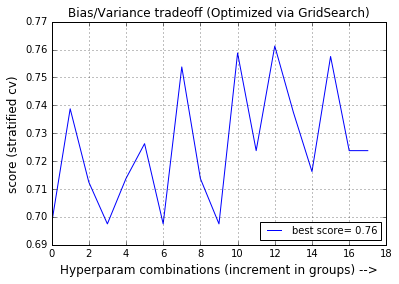

The model fit on training set; scores computed on the test set.

Detailed classification report:
-------------------------------
             precision    recall  f1-score   support

          0       0.79      0.82      0.81       142
          1       0.52      0.47      0.49        58

avg / total       0.71      0.72      0.72       200

-------------------------------
Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.53  0.47]]


In [13]:
algoName='SVM Poly'
bestParDict={}
bestParDict['kernel']='poly'
estimator='clf=svm.SVC'
tune_params = {'gamma': np.logspace(-3, 0, 3),
                       'coef0': np.logspace(-2,2,3),
                       'degree': [2,3]}

(clf, cm_normalized, bestScore, f1Score)= AnalyzeData(
    X, y, estimator, tune_params, bestParDict, class_names, withProbability=True, crossVal=10)
clfs_plots[algoName]=(clf, cm_normalized)
algoMetric[algoName]=[bestScore, f1Score]

-  SVM RBF

Best parameters set found on development set:
{'C': 100.0, 'gamma': 0.001}


Grid scores on development set:
--------------------
1 0.698 (+/-0.007) for {'C': 0.001, 'gamma': 0.001}
2 0.698 (+/-0.007) for {'C': 0.001, 'gamma': 0.031622776601683791}
3 0.698 (+/-0.007) for {'C': 0.001, 'gamma': 1.0}
4 0.698 (+/-0.007) for {'C': 0.01, 'gamma': 0.001}
5 0.698 (+/-0.007) for {'C': 0.01, 'gamma': 0.031622776601683791}
6 0.698 (+/-0.007) for {'C': 0.01, 'gamma': 1.0}
7 0.698 (+/-0.007) for {'C': 0.10000000000000001, 'gamma': 0.001}
8 0.698 (+/-0.007) for {'C': 0.10000000000000001, 'gamma': 0.031622776601683791}
9 0.698 (+/-0.007) for {'C': 0.10000000000000001, 'gamma': 1.0}
10 0.698 (+/-0.007) for {'C': 1.0, 'gamma': 0.001}
11 0.756 (+/-0.075) for {'C': 1.0, 'gamma': 0.031622776601683791}
12 0.698 (+/-0.007) for {'C': 1.0, 'gamma': 1.0}
13 0.730 (+/-0.054) for {'C': 10.0, 'gamma': 0.001}
14 0.759 (+/-0.074) for {'C': 10.0, 'gamma': 0.031622776601683791}
15 0.698 (+/-0.007) for {'C': 10.0, 'ga

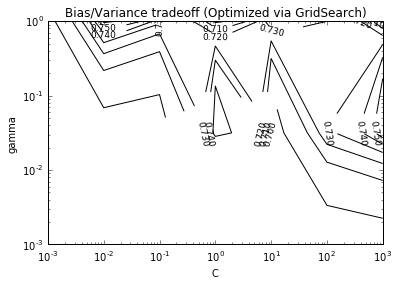

The model fit on training set; scores computed on the test set.

Detailed classification report:
-------------------------------
             precision    recall  f1-score   support

          0       0.79      0.82      0.81       142
          1       0.52      0.47      0.49        58

avg / total       0.71      0.72      0.72       200

-------------------------------
Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.53  0.47]]


In [14]:
algoName='SVM RBF'
bestParDict={}
bestParDict['kernel']='rbf'
estimator='clf=svm.SVC'
tune_params = {'C': np.logspace(-3, 3, 7), 
               'gamma': np.logspace(-3, 0, 3)}

(clf, cm_normalized, bestScore, f1Score)= AnalyzeData(
    X, y, estimator, tune_params, bestParDict, class_names, withProbability=True, xscale='log', yscale='log', crossVal=10)
clfs_plots[algoName]=(clf, cm_normalized)
algoMetric[algoName]=[bestScore, f1Score]

-  kNearest Neighbors (uniform weight)

Best parameters set found on development set:
{'n_neighbors': 12.0}


Grid scores on development set:
--------------------
1 0.693 (+/-0.108) for {'n_neighbors': 1.0}
2 0.740 (+/-0.053) for {'n_neighbors': 12.0}
3 0.730 (+/-0.033) for {'n_neighbors': 23.0}
4 0.720 (+/-0.053) for {'n_neighbors': 34.0}
5 0.725 (+/-0.034) for {'n_neighbors': 45.0}
6 0.711 (+/-0.036) for {'n_neighbors': 56.0}
7 0.706 (+/-0.030) for {'n_neighbors': 67.0}
8 0.704 (+/-0.029) for {'n_neighbors': 78.0}
9 0.705 (+/-0.029) for {'n_neighbors': 89.0}
10 0.701 (+/-0.013) for {'n_neighbors': 100.0}




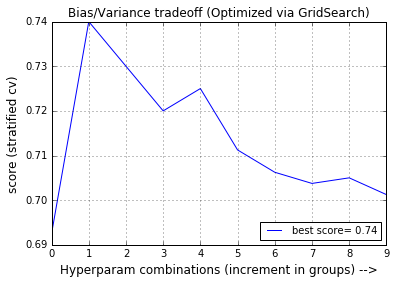

The model fit on training set; scores computed on the test set.

Detailed classification report:
-------------------------------
             precision    recall  f1-score   support

          0       0.75      0.93      0.83       142
          1       0.57      0.22      0.32        58

avg / total       0.69      0.72      0.68       200

-------------------------------
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.78  0.22]]


In [15]:
algoName='kNN uniform'
bestParDict={}
bestParDict['weights']='uniform'
estimator='clf=KNeighborsClassifier'
tune_params = {'n_neighbors': np.linspace(1, 100, 10)}

(clf, cm_normalized, bestScore, f1Score)= AnalyzeData(
    X, y, estimator, tune_params, bestParDict, class_names, withProbability=True, crossVal=10)
clfs_plots[algoName]=(clf, cm_normalized)
algoMetric[algoName]=[bestScore, f1Score]

-  kNearest Neighbors (weighted)

Best parameters set found on development set:
{'n_neighbors': 12.0}


Grid scores on development set:
--------------------
1 0.693 (+/-0.108) for {'n_neighbors': 1.0}
2 0.739 (+/-0.061) for {'n_neighbors': 12.0}
3 0.730 (+/-0.033) for {'n_neighbors': 23.0}
4 0.731 (+/-0.047) for {'n_neighbors': 34.0}
5 0.725 (+/-0.035) for {'n_neighbors': 45.0}
6 0.720 (+/-0.025) for {'n_neighbors': 56.0}
7 0.710 (+/-0.031) for {'n_neighbors': 67.0}
8 0.705 (+/-0.030) for {'n_neighbors': 78.0}
9 0.706 (+/-0.031) for {'n_neighbors': 89.0}
10 0.703 (+/-0.018) for {'n_neighbors': 100.0}




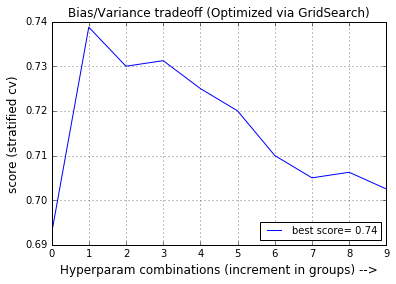

The model fit on training set; scores computed on the test set.

Detailed classification report:
-------------------------------
             precision    recall  f1-score   support

          0       0.77      0.89      0.82       142
          1       0.56      0.33      0.41        58

avg / total       0.71      0.73      0.71       200

-------------------------------
Normalized confusion matrix
[[ 0.89  0.11]
 [ 0.67  0.33]]


In [16]:
algoName='kNN weighted'
bestParDict={}
bestParDict['weights']='distance'
estimator='clf=KNeighborsClassifier'
tune_params = {'n_neighbors': np.linspace(1, 100, 10)}

(clf, cm_normalized, bestScore, f1Score)= AnalyzeData(
    X, y, estimator, tune_params, bestParDict, class_names, withProbability=True, crossVal=10)
clfs_plots[algoName]=(clf, cm_normalized)
algoMetric[algoName]=[bestScore, f1Score]

-  Neural Network

Best parameters set found on development set:
{'momentum': 0.1, 'learning_rate_init': 1.0, 'hidden_layer_sizes': (16,)}


Grid scores on development set:
--------------------
1 0.555 (+/-0.348) for {'momentum': 0.1, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (1,)}
2 0.539 (+/-0.388) for {'momentum': 0.5, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (1,)}
3 0.698 (+/-0.007) for {'momentum': 0.9, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (1,)}
4 0.698 (+/-0.007) for {'momentum': 0.1, 'learning_rate_init': 0.031622776601683791, 'hidden_layer_sizes': (1,)}
5 0.706 (+/-0.025) for {'momentum': 0.5, 'learning_rate_init': 0.031622776601683791, 'hidden_layer_sizes': (1,)}
6 0.743 (+/-0.103) for {'momentum': 0.9, 'learning_rate_init': 0.031622776601683791, 'hidden_layer_sizes': (1,)}
7 0.740 (+/-0.102) for {'momentum': 0.1, 'learning_rate_init': 1.0, 'hidden_layer_sizes': (1,)}
8 0.741 (+/-0.104) for {'momentum': 0.5, 'learning_rate_init': 1.0, 'hidden_layer_sizes': (1,)}


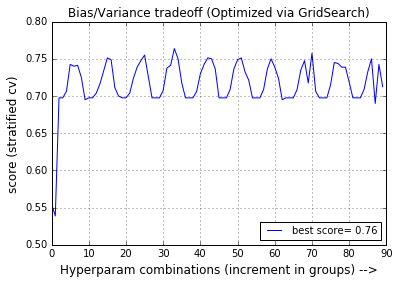

The model fit on training set; scores computed on the test set.

Detailed classification report:
-------------------------------
             precision    recall  f1-score   support

          0       0.83      0.81      0.82       142
          1       0.56      0.59      0.57        58

avg / total       0.75      0.74      0.75       200

-------------------------------
Normalized confusion matrix
[[ 0.81  0.19]
 [ 0.41  0.59]]


In [17]:
algoName='Neural Network'
bestParDict={}
bestParDict['solver']='sgd'
bestParDict['activation']='logistic'
estimator='clf=MLPClassifier'
tune_params = {'hidden_layer_sizes': zip(range(1,50,5)),
              'momentum': [0.1,0.5,0.9],
              'learning_rate_init': np.logspace(-3,0,3)}

(clf, cm_normalized, bestScore, f1Score)= AnalyzeData(
    X, y, estimator, tune_params, bestParDict, class_names, withProbability=True, crossVal=10)
clfs_plots[algoName]=(clf, cm_normalized)
algoMetric[algoName]=[bestScore, f1Score]

### Plotting
-  Plot setup

In [18]:
n_algos=len(clfs_plots)
n_pltsInRow=2
n_pltsInCol=int(np.ceil(float(n_algos)/n_pltsInRow))

-  Confusion matrix

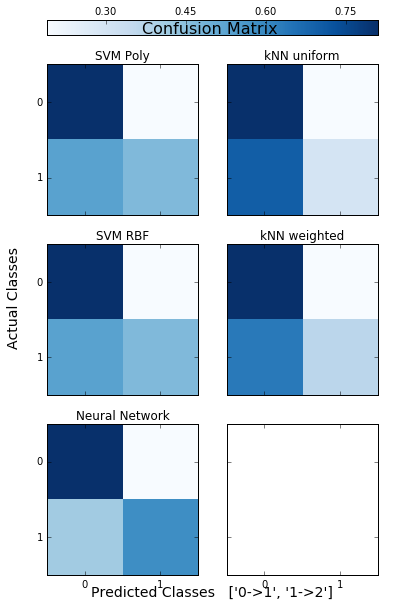

In [19]:
F = plt.figure(1, (8, 8)) #8 inch x 8 inch image
F.subplots_adjust(left=0.2, right=0.4)
F.suptitle('Confusion Matrix', fontsize=16, x=0.5, y=0.98)
#

grid = AxesGrid(F, 111,
                    nrows_ncols=(n_pltsInCol , n_pltsInRow),
                    axes_pad=0.4,
                    share_all=True,
                    label_mode="L",
                    cbar_location="top",
                    cbar_mode="single",
                    )
xaxis_classname=[str(a)+'->'+str(b) for a,b in zip(range(len(class_names)), class_names)]
createFrame(F, 'Predicted Classes   {0}'.format(xaxis_classname), 'Actual Classes', xpad=10, ypad=0)
i=0
for algo in clfs_plots.keys():
    _, confusionMatrix=clfs_plots[algo]
    im=plotConfusionMatrix(confusionMatrix, class_names, grid[i], title=algo)
    i+=1

grid.cbar_axes[0].colorbar(im)
for cax in grid.cbar_axes:
    cax.toggle_label(True)
plt.tight_layout()
plt.show()

-  Learning curves

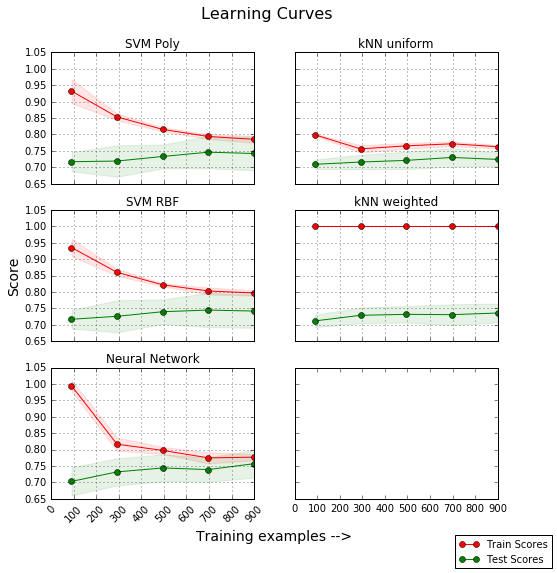

In [20]:
#F = plt.figure(1, (8, 8)) #8 inch x 8 inch image
#F.subplots_adjust(left=0.1, right=1)
#
import warnings
warnings.filterwarnings('ignore')

F, grid = plt.subplots(n_pltsInCol, n_pltsInRow, sharex=True, sharey=True)
F.set_size_inches(8, 8) #8 x 8 inches
F.suptitle('Learning Curves', fontsize=16, x=0.5, y=0.98)

#xaxis_classname=[str(x)+'->'+str(y) for x,y in zip(range(len(class_names)), class_names)]
createFrame(F, 'Training examples -->', 'Score', xpad=30, ypad=30)
i=0
cv=cross_validation.StratifiedKFold(y, n_folds=10)
for algo in clfs_plots.keys():
    row=int(i/n_pltsInRow)
    col=int(i%n_pltsInRow)
    clf, _ = clfs_plots[algo]
    start_time = time.time()
    (l1,l2, rtnGridObj)=plotLearningCurve(clf, X, y, algo, grid[row][col], cv=cv)
    algoRunTime=round(time.time() - start_time, 2)
    algoMetric[algoName].append(algoRunTime)
    i+=1
    
#plt.tight_layout()
for tick in rtnGridObj.get_xticklabels():
    tick.set_rotation(45)
F.legend((l1, l2), ('Train Scores', 'Test Scores'), loc='lower right')
plt.show()

-  ROC

#### Weird learnings
-  When class is labelEncoded and GridSearch is optimized for 'f1' score, accuracy results are very weird.
  -  e.g. Weka shows around 74-76% accuracy on same params.
  -  scikit with 'accuracy' tuning for GridSearch shows similar
    -  however when search s based on 'f1' accuracy is 84%, while for neural network confusion matrix is very different for different runs